Задание: сборка PDF документа

Используя данные по посещаемости библиотек в районах Москвы
https://video.ittensive.com/python-advanced/data-7361-2019-11-28.utf.json
постройте круговую диаграмму суммарной посещаемости (NumOfVisitors) 20 наиболее популярных районов Москвы.

Создайте PDF отчет, используя файл
https://video.ittensive.com/python-advanced/title.pdf
как первую страницу. На второй странице выведите итоговую диаграмму, самый популярный район Москвы и число посетителей библиотек в нем.

Басманный район 765402.0


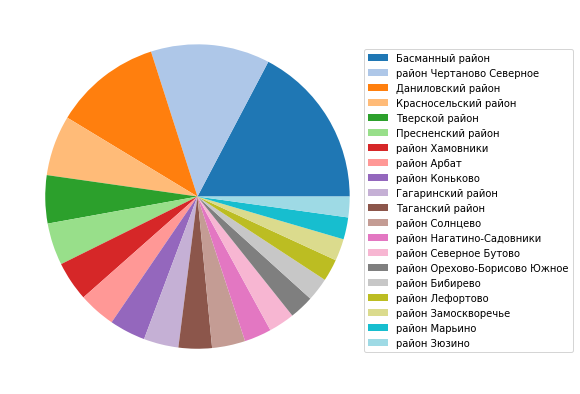

In [2]:
# Используя данные по посещаемости библиотек в районах Москвы
# Постройте круговую диаграмму суммарной посещаемости (NumOfVisitors) 20 наиболее популярных районов Москвы.

#https://video.ittensive.com/python-advanced/data-7361-2019-11-28.utf.json
import json
import requests 
import pandas as pd
import matplotlib.pyplot as plt

from reportlab.pdfgen import canvas
from reportlab.lib import pagesizes
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.lib.utils import ImageReader
from PyPDF2 import PdfFileMerger, PdfFileReader  
from PIL import Image  # для сохранения извлеченных изображений

r = requests.get("https://video.ittensive.com/python-advanced/data-7361-2019-11-28.utf.json")

# вычленим из данных только число посетитетелй и название библиотеки заполненли отсутсв.значение нулями
data = pd.DataFrame(json.loads(r.content)).fillna(value=0) # загрузили json в дата фрейм пандаса пустые занчения заместили нулями

# для для извлечения района нам понадобится вспомагательная функция которая будет брать значение из серии ObjectAddress, находить в этом значении поле District 
# приводить это поле к списку все найденые значения и возвращать первое значение из этого списка, по факту будет вычлинять первый найденый District из словаря ObjectAddress
def extract_district (x):
    return list(map(lambda a: a["District"], x))[0]

data["District"] = data["ObjectAddress"].apply(extract_district)  # извлечем район 
data_sum = data.groupby("District").sum("NumOfVisitors").sort_values("NumOfVisitors", ascending=False)  # суммируем  посетителей по районам

# построим круговую диаграмму 
fig = plt.figure(figsize=(12, 7))
area = fig.add_subplot(1, 1, 1)
popular20_data = data_sum[0:20]["NumOfVisitors"]  # сделаем срез первых 20 библиотек с наибольшим кол-вом посетителей (так как ранее отсортировали по убыванию)
popular20_data.plot.pie(ax=area, label="",  labels=[""]*20, cmap="tab20")  # рисуем пай
plt.legend(popular20_data.index, bbox_to_anchor=(1.4,0.9,0.1,0))  # легенду располагаем сбоку от диаграммы  
plt.savefig("pie1.png")  # сохранили нашу круговую диаграмму как картинку 

#Создайте PDF отчет, используя файл title.pdf как первую страницу. 
#На второй странице выведите итоговую диаграмму, самый популярный район Москвы и число посетителей библиотек в нем.

pdfmetrics.registerFont(TTFont("Trebuchet", "Trebuchet.ttf")) # для начала регистирируем шрифт
PDF = canvas.Canvas("popular20-libraries.pdf", pagesize=pagesizes.A4) # выставим размер холста А4

# выведем заголовок 
PDF.setFont("Trebuchet", 36)  # шрифт и размер заголовка
PDF.drawString(100, 750, "Посещаемость библиотек") 
PDF.drawString(100, 700, "в районах Москвы")
# сформируем данные: самый популярный р-н и число посетителей библиотек в нем 
best_District = popular20_data.index[0]
best_values = popular20_data[0]
# добавим в PDF строчку самый популярный район Москвы и число посетителей библиотек в нем.
PDF.setFont("Trebuchet", 14)
PDF.drawString(50, 75, f"Самый популярный район Москвы: {best_District}" )
PDF.drawString(50, 50, f"Число посетителей библиотек в этом районе: {int(best_values)}" )
# номер страницы
PDF.setFont("Trebuchet", 13)
PDF.drawString(550, 820, "2")
# отрисуем изображении диаграммы при помощи ImageReader 
PDF.drawImage(ImageReader("pie1.png"), -250, 150)
PDF.save()  # сохраним PDF 

# объединение в отчет (в один файл)
files = ["title.pdf", "popular20-libraries.pdf"]
merger = PdfFileMerger()
for filename in files:
    merger.append(PdfFileReader(open(filename, "rb")))
# добавим мета данные 
merger.addMetadata({
    '/Producer': "Плотников Александр",
    '/Author': "Плотников Александр",
    '/Creator': "Плотников Александр",
    '/Copyright': "2022",
    '/Title': "Культурная статистика Москвы"   
})
merger.write("report_sam.pdf")
print(best_District, best_values)
